# Completeness Test - 02
<hr>


In [1]:
import os
import sys
import glob
import numpy as np
from astropy import units as u 
from astropy import coordinates
from astropy.io import fits
import matplotlib.pyplot as plt
import aplpy

%matplotlib inline

In [2]:
def generate_sample(flux=1.02e-04, freq='241.23GHz', center=[65.8158364, -1.3425182], 
    PB=24.0, beam=0.2, imagesize=48.0, spacing=10, outputfile="sample.dat"):
    """
    Generate grid sample, with spacing parameter as input
    spacing is multiple of beamsize
    """

    PB_in_deg = PB/3600.0

    distance_between_source = spacing*beam

    grid = imagesize/(distance_between_source)

    number = (grid)**2

    print grid, number

    grid = int(grid)
    print "Grid size : ", grid, "x", grid, "\nTotal number of sample: ", grid*grid

    start  = [center[0] - imagesize/(2*3600) + 0.5*distance_between_source/3600.0, center[1] - imagesize/(2*3600) + 0.5*distance_between_source/3600.0]

    sample = []
    for i in range(grid):
        for j in range(grid):
            ra = start[0] + distance_between_source/3600. * i # degree
            dec = start[1] + distance_between_source/3600. * j

            # for easy transformation
            #c = coordinates.SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='fk5', equinox='J2000') 
            #pos = 'J2000 ' + str(c.to_string('hmsdms')) # unicode to str
            # Error: ancient astropy in ALMA Cluster!

            # flux scalling from PB
            theta_from_the_center = np.sqrt((ra - center[0])**2 + (dec - center[1])**2) # in degree
            scaled_flux = flux * np.exp(-np.log(2) * (2*theta_from_the_center/PB_in_deg)**2)

            #pos = 'J2000 ' + str(ra) + 'deg ' + str(dec) + 'deg'

            sample.append([ra, dec, scaled_flux])#, 'Jy', freq, 'point']) 

    # write to file
#     with open(outputfile, 'w') as ofile:
#         for item in sample:
#             for i in item:
#                 ofile.write("%s " % i)
#             ofile.write('\n')

    return np.array(sample) # ra, dec

In [3]:
sample = generate_sample()

24.0 576.0
Grid size :  24 x 24 
Total number of sample:  576


### Try overplot

INFO: Setting slices=[0, 0] [aplpy.core]


indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in param

INFO: Setting slices=[0, 0] [aplpy.core]


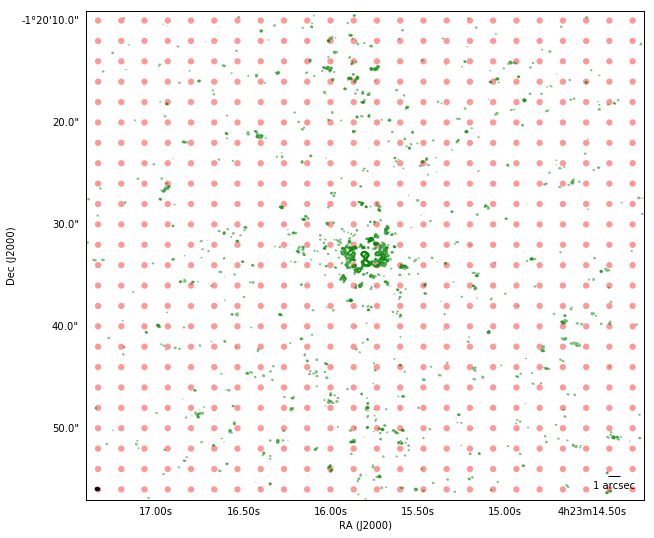

In [4]:
B6 = '../compareImage/images/J0423-0120_B6.fits'
rmsB6 = 3.4E-05

multp = np.array([2.5, 3, 3.5, 4.5, 5, 5.5, 6, 10, 100, 1000, 10000]) # sigma
lvlB6 = rmsB6*multp

fig = aplpy.FITSFigure(B6);
fig.add_beam()
fig.beam.set_color('black')
fig.add_scalebar(1 * u.arcsecond)
fig.scalebar.set_label('1 arcsec')
fig.scalebar.set_color("black")
fig.show_contour(B6, colors='green', levels=lvlB6, alpha=0.5);

## add marker for the position of fake source
fig.show_markers(sample[:,0], sample[:,1], edgecolor='none', facecolor='red', marker='o', s=40, alpha=0.4);

In [5]:
def plot_fits(fitsfile, levels, center, PB=False, maskradius=False, rmsregion=False, sourcelist=False, showlabel=False, showcontour=True, showimage=False):
    """Function to plot a single fits file."""
    fig = aplpy.FITSFigure(fitsfile)
    # beam
    fig.add_beam() 
    fig.beam.set_color('black')
    # scalebar
    fig.add_scalebar(1 * u.arcsecond) 
    fig.scalebar.set_label('1 arcsec')
    fig.scalebar.set_color("black")

    # contour of fits file
    if showcontour:
        fig.show_contour(fitsfile, colors='blue', levels=levels, alpha=0.6)

    # primary beam circle
    if PB:
        fig.show_circles(center[0], center[1], PB/2.0, edgecolor='blue') 
    
    # mask
    if maskradius:
        fig.show_circles(center[0], center[1], maskradius, edgecolor='green', facecolor='green', alpha=0.3) 
    
    # region to calculate RMS
    if rmsregion:
        fig.show_regions(rmsregion)
        fig.show_circles(center[0], center[1], 0.004167, edgecolor='red', facecolor='red', alpha=0.2)
    
    # marker for sextractor result
    if sourcelist:
        ra, dec, flux, label = sourcelist
        marker_size =  80 * flux/flux.max() + 10
        fig.show_markers(ra, dec, edgecolor='black', facecolor='none', marker='o', s=marker_size, alpha=0.9)

        if showlabel:
            shifted = 0.00032
            for i, lbl in enumerate(label): 
                fig.add_label(ra[i], dec[i]-shifted, lbl) # label for sextractor result
    
    # show colormap
    if showimage:
        fig.show_colorscale()

In [6]:
def read_sexofile(filename = "J0423-0120_B3.cat"):
    """Function to read sextractor output file."""
    pars = []
    # only get the header
    with open(filename, 'r') as ifile:
        for line in ifile:
            if line[0] == '#': 
                pars.append(line.split()[2])
                
    print 'Col names: ', pars
    
    # get the data
    data = np.genfromtxt(filename, names=pars) # already in np array
    return data

In [29]:
dirname = './cttest01/'
sexofiles = []
fitsfiles = []
statfiles = []
fluxmin = 6.8e-05
fluxmax = 3.4e-04
nflux   = 16
flux_injected = []
for flux in np.linspace(fluxmin, fluxmax, nflux):
    flux_injected.append(flux)
    sexofiles.append(dirname+'injected_flux_'+str(flux)+'.cont.cat')
    fitsfiles.append(dirname+'injected_flux_'+str(flux)+'.cont.fits')
    statfiles.append(dirname+'injected_flux_'+str(flux)+'.cont.stat')

In [8]:
sexofiles

['./cttest01/injected_flux_6.8e-05.cont.cat',
 './cttest01/injected_flux_8.61333333333e-05.cont.cat',
 './cttest01/injected_flux_0.000104266666667.cont.cat',
 './cttest01/injected_flux_0.0001224.cont.cat',
 './cttest01/injected_flux_0.000140533333333.cont.cat',
 './cttest01/injected_flux_0.000158666666667.cont.cat',
 './cttest01/injected_flux_0.0001768.cont.cat',
 './cttest01/injected_flux_0.000194933333333.cont.cat',
 './cttest01/injected_flux_0.000213066666667.cont.cat',
 './cttest01/injected_flux_0.0002312.cont.cat',
 './cttest01/injected_flux_0.000249333333333.cont.cat',
 './cttest01/injected_flux_0.000267466666667.cont.cat',
 './cttest01/injected_flux_0.0002856.cont.cat',
 './cttest01/injected_flux_0.000303733333333.cont.cat',
 './cttest01/injected_flux_0.000321866666667.cont.cat',
 './cttest01/injected_flux_0.00034.cont.cat']

In [10]:
PB = 24.0 # arcsec
beam = 0.2 # arcsec
center = [65.8158364, -1.3425182]
multp = np.array([3, 3.5, 4.5, 5, 5.5, 6, 10, 100, 1000])

In [11]:
dirtol = 0.1/3600 # arcsec to degree
print dirtol

2.77777777778e-05


In [12]:
def find_match(injected_source, extracted_source, dirtol=2.78E-05):
    """Brute force to match between injected source and extracted source"""
    list_of_match = []
    for s in injected_source:
        match = False
        ra, dec = s[0], s[1]
        list_ra, list_dec = extracted_source[:,0], extracted_source[:,1]
        
        # find distance from that list
        # using euclidean trigonometry [not a spherical]
        list_dist = np.sqrt((list_ra - ra)**2 + (list_dec - dec)**2)
        idx = np.where(list_dist <= dirtol) # index of match object
        
        if len(idx[0]) > 0:
            list_of_match.append(extracted_source[idx][0])
            if len(idx[0]) > 1:
                print "More than 1 source matched"
        
    return np.array(list_of_match)

Col names:  ['NUMBER', 'FLUX_ISO', 'FLUXERR_ISO', 'FLUX_AUTO', 'FLUXERR_AUTO', 'FLUX_BEST', 'FLUXERR_BEST', 'BACKGROUND', 'THRESHOLD', 'ISOAREA_IMAGE', 'ISOAREAF_IMAGE', 'X_IMAGE', 'Y_IMAGE', 'ALPHA_SKY', 'DELTA_SKY', 'ALPHA_J2000', 'DELTA_J2000']
Found:  10
Completeness:  1.73611111111 %
INFO: Setting slices=[0, 0] [aplpy.core]
Col names:  ['NUMBER', 'FLUX_ISO', 'FLUXERR_ISO', 'FLUX_AUTO', 'FLUXERR_AUTO', 'FLUX_BEST', 'FLUXERR_BEST', 'BACKGROUND', 'THRESHOLD', 'ISOAREA_IMAGE', 'ISOAREAF_IMAGE', 'X_IMAGE', 'Y_IMAGE', 'ALPHA_SKY', 'DELTA_SKY', 'ALPHA_J2000', 'DELTA_J2000']
Found:  16
Completeness:  2.77777777778 %
INFO: Setting slices=[0, 0] [aplpy.core]
Col names:  ['NUMBER', 'FLUX_ISO', 'FLUXERR_ISO', 'FLUX_AUTO', 'FLUXERR_AUTO', 'FLUX_BEST', 'FLUXERR_BEST', 'BACKGROUND', 'THRESHOLD', 'ISOAREA_IMAGE', 'ISOAREAF_IMAGE', 'X_IMAGE', 'Y_IMAGE', 'ALPHA_SKY', 'DELTA_SKY', 'ALPHA_J2000', 'DELTA_J2000']
Found:  22
Completeness:  3.81944444444 %
INFO: Setting slices=[0, 0] [aplpy.core]
Col nam

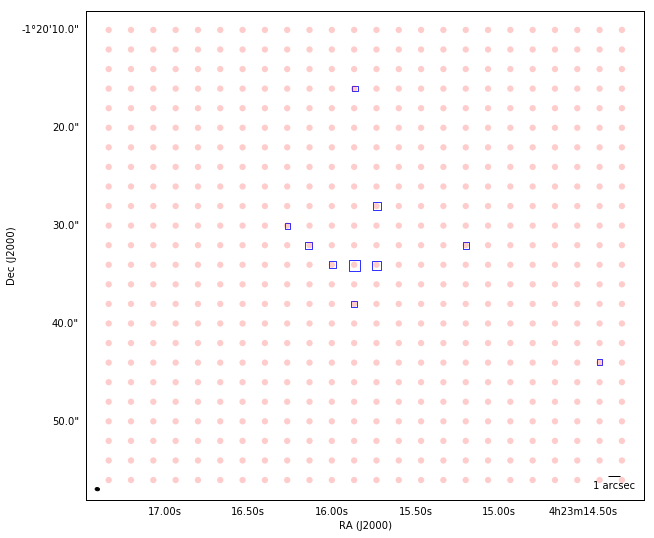

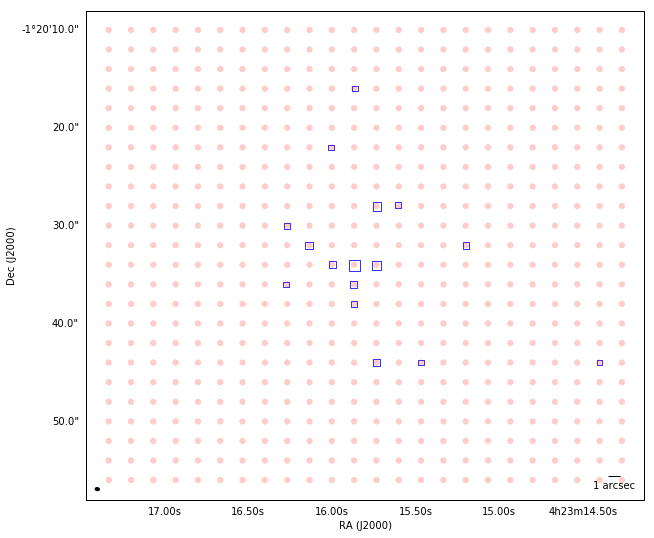

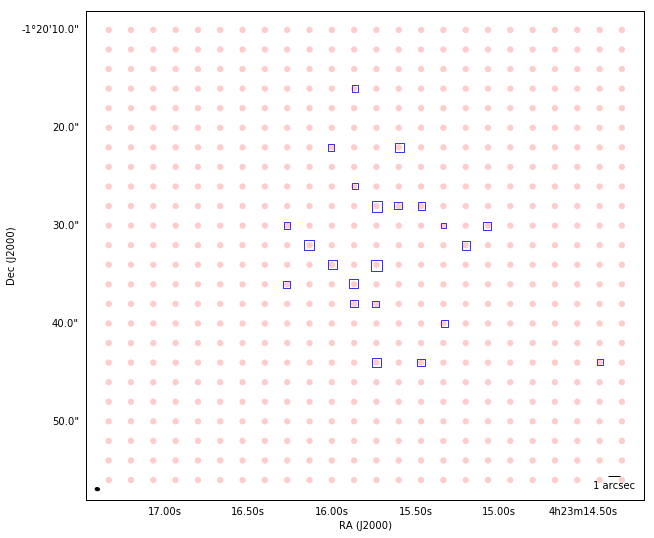

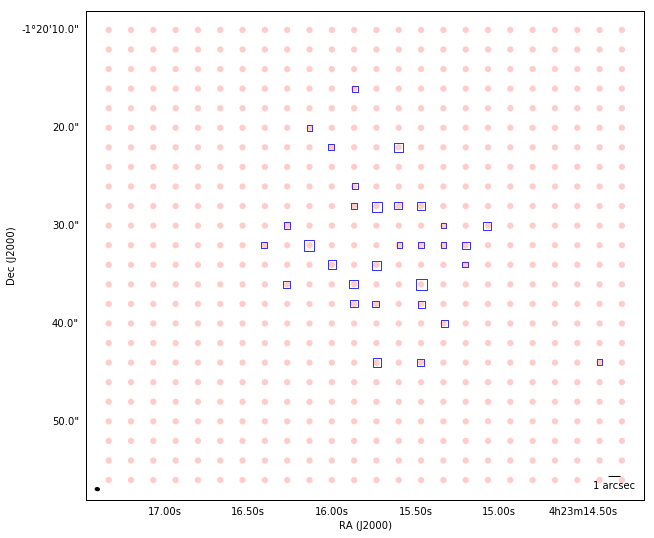

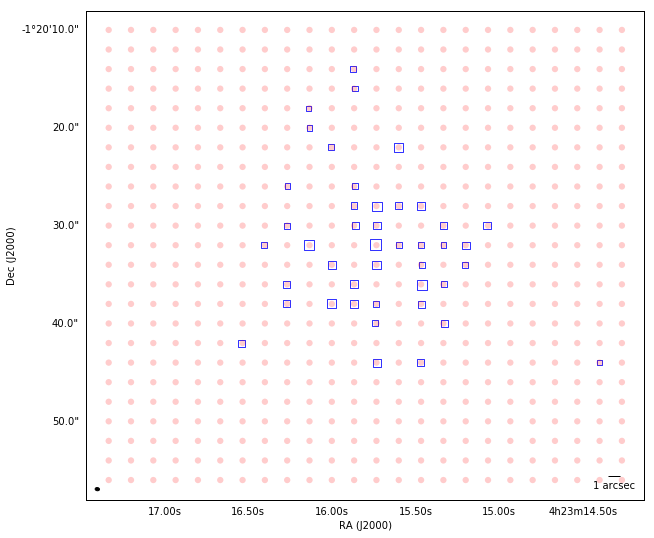

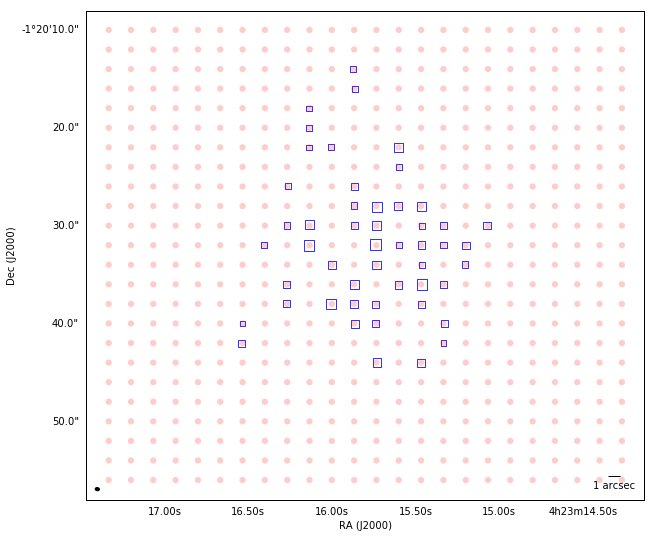

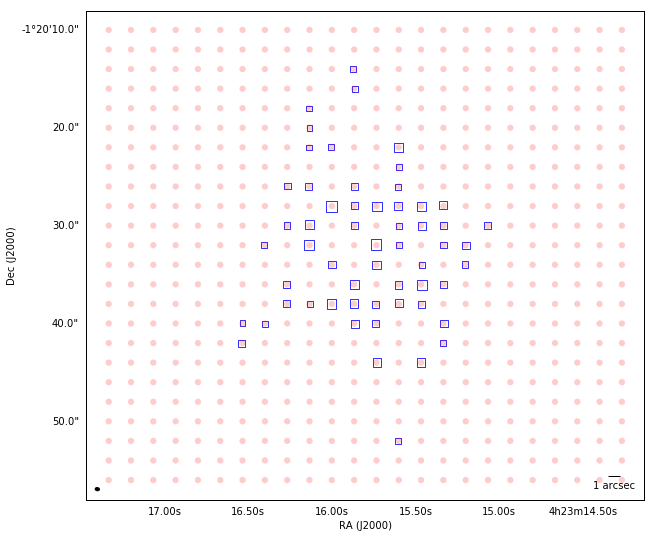

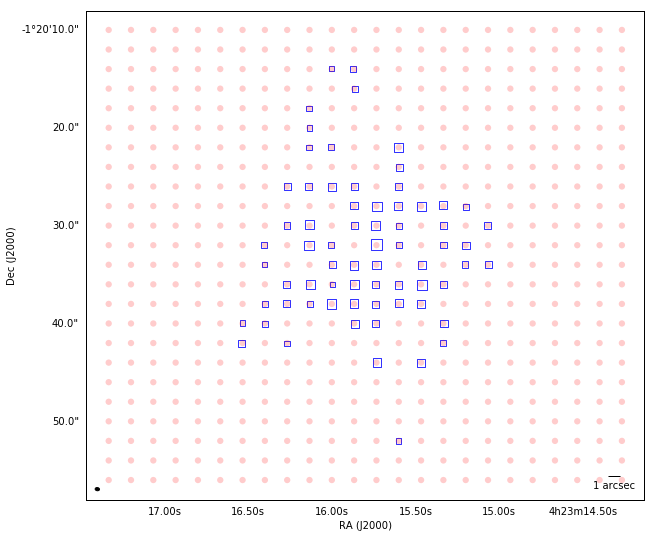

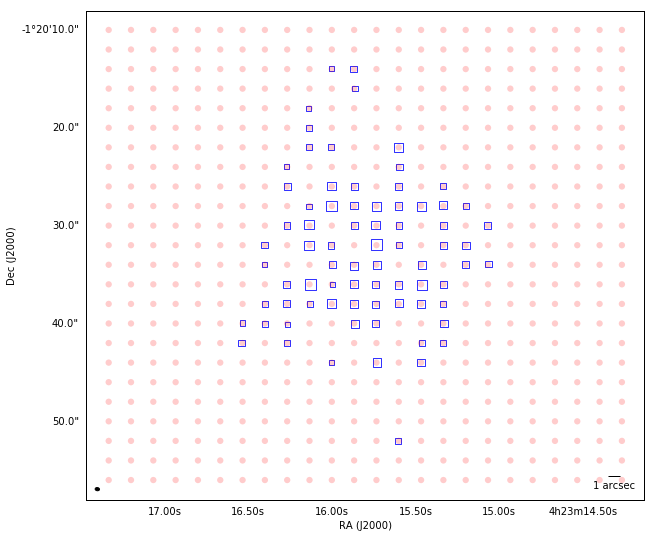

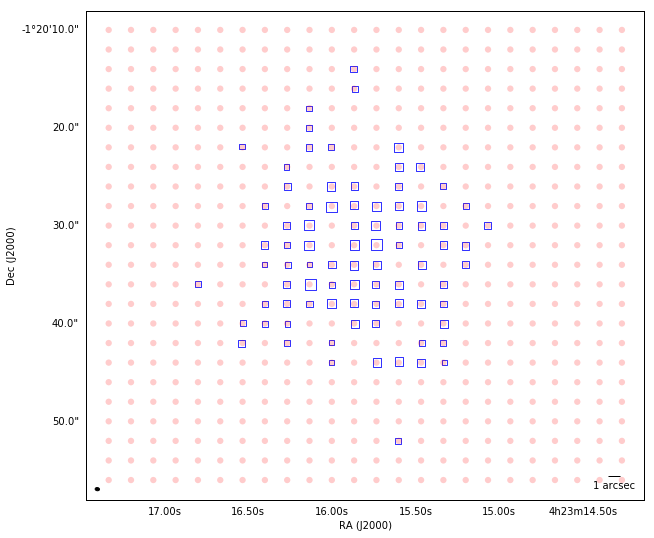

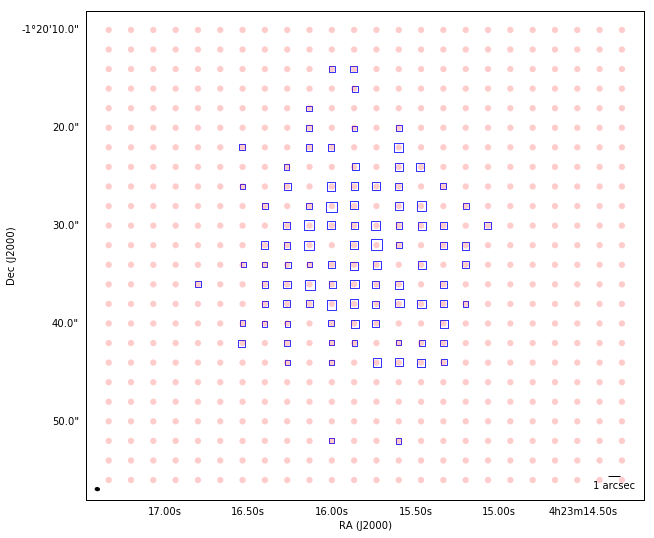

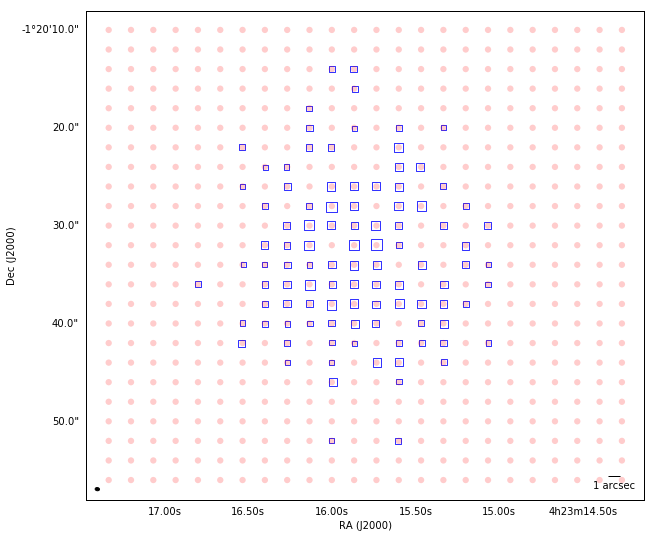

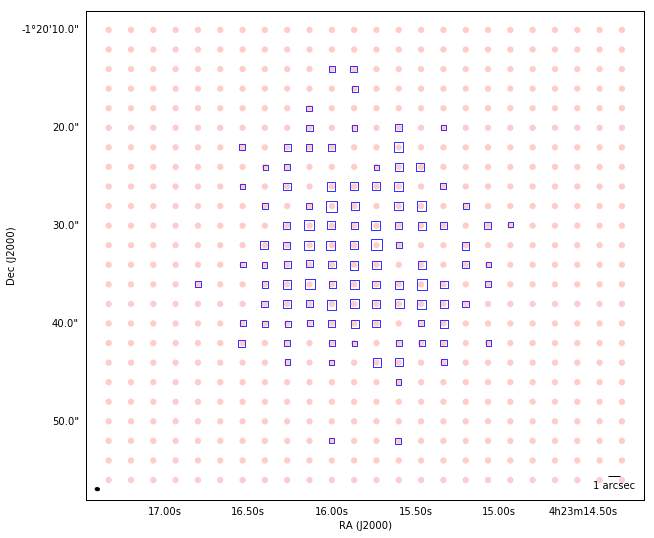

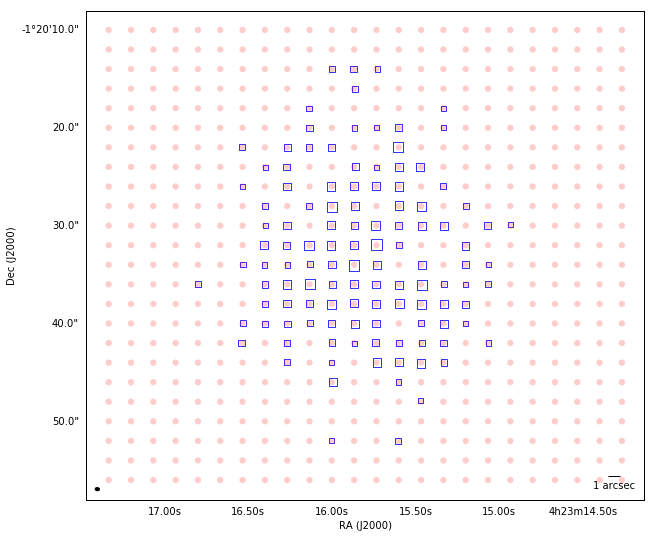

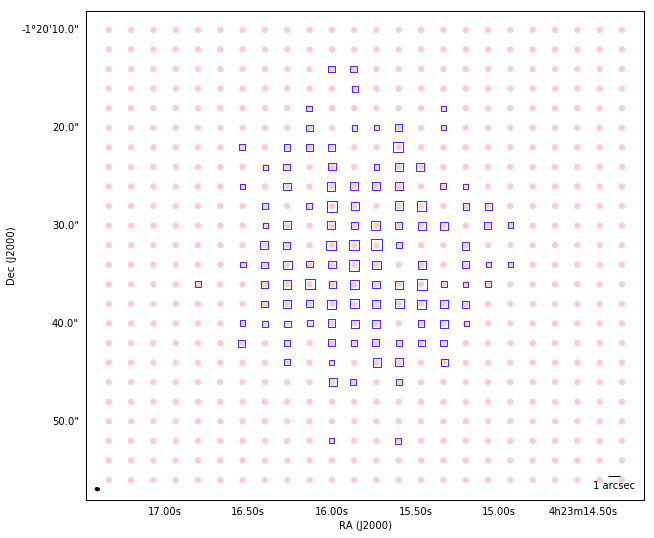

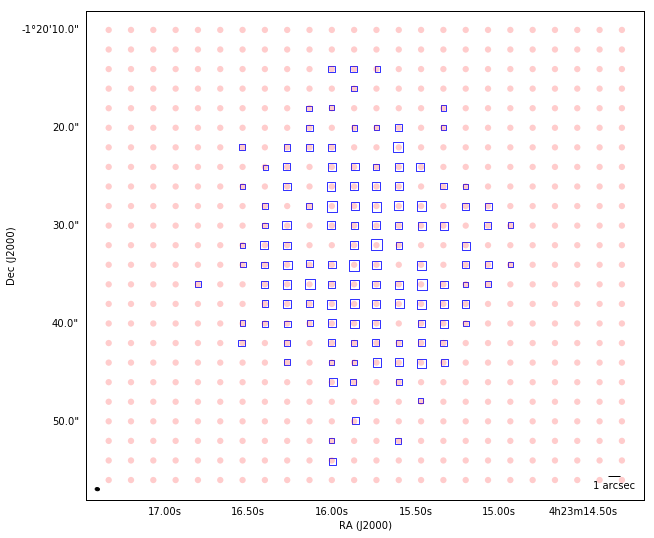

In [17]:
nsample = len(sample)
complete = []
for i, fitsfile in enumerate(fitsfiles):
    #fitsfile = './images/injected.ms.afterclean.withmask.cont.fits'
    #levels = 3.742764e-05*multp
    data = read_sexofile(sexofiles[i])
    extracted = np.array([data['ALPHA_J2000'], data['DELTA_J2000'], data['FLUX_BEST'], data['NUMBER'].astype('int')])
    ext = extracted.T
    res =  find_match(sample, ext, dirtol=2.78E-05)
    print "Found: ", len(res)
    comp = float(len(res))/nsample * 100
    print "Completeness: ", comp, "%"
    complete.append(comp)
    
    fig = aplpy.FITSFigure(fitsfile)

    # beam and scalebar
    fig.add_beam()
    fig.beam.set_color('black')
    fig.add_scalebar(1 * u.arcsecond)
    fig.scalebar.set_label('1 arcsec')
    fig.scalebar.set_color("black")

    # contour fits
    # fig.show_contour(fitsfile, colors='blue', levels=levels, alpha=0.6)

    # primary beam circle
    fig.show_circles(center[0], center[1], PB/2.0, edgecolor='green')

    #ra, dec, flux, label = selected_data_1 # uninjected
    #marker_size =  80 * flux/flux.max() + 10
    #fig.show_markers(ra, dec, edgecolor='red', facecolor='none', marker='o', s=marker_size, alpha=0.8)

    # matched
    ra, dec, flux, label = res[:,0], res[:,1], res[:,2], res[:,3]
    marker_size =  100 * flux/flux.max() + 20
    fig.show_markers(ra, dec, edgecolor='blue', facecolor='none', marker='s', s=marker_size, alpha=0.8)

    # injected source
    fig.show_markers(sample[:,0], sample[:,1], edgecolor='none', facecolor='red', marker='o', s=40, alpha=0.2);
    fig.save(fitsfile[:-5]+'.png')

In [18]:
complete

[1.7361111111111112,
 2.7777777777777777,
 3.8194444444444446,
 5.381944444444445,
 7.465277777777778,
 8.680555555555555,
 9.895833333333332,
 11.805555555555555,
 13.020833333333334,
 14.23611111111111,
 16.666666666666664,
 17.53472222222222,
 18.40277777777778,
 20.13888888888889,
 19.96527777777778,
 21.52777777777778]

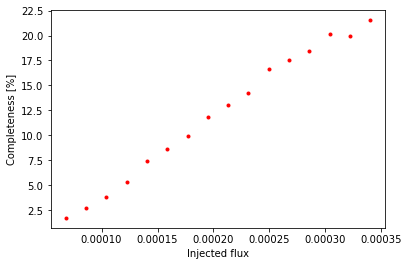

In [21]:
plt.plot(flux_injected, complete, 'r.')
plt.xlabel("Injected flux")
plt.ylabel("Completeness [%]")

-> x-axis should be SNR!

I use rms from original image to make a grid in Flux

2rms -- 10rms devided by 16 samples

### Comments
- the results are very clustered on the center. Am I wrong in scaling the primary beam attenuation? Do we really need this scaling?
- it only 20% complete for flux density 0.34 mJy, is it normal? should I change how to select flux-grid?
- how to get SNR for x-axis?

### If I plot 'rms' from <code>annulus-region</code> defined as before (first notebook)

stats = []
for statfile in statfiles:
    stats.append(np.loadtxt(statfile))

In [41]:
rms = []
for stat in stats:
    rms.append(stat[3])

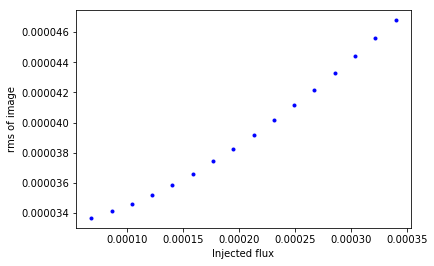

In [43]:
plt.plot(flux_injected, rms, 'b.')
plt.xlabel("Injected flux")
plt.ylabel("rms of image")

In [45]:
print flux_injected[0]/rms[0]
print flux_injected[-1]/rms[-1]

2.01884712547
7.26776342917
